**Проект заточен на то, чтобы предсказать культуру производственной безопасности (КПБ) каждого работника с помощью методов ML и DL. В конце концов, выбрать наилучшую модель для дальнейшего пользования университетом РГУ нефти и газа имени Губкина.**

# Импорт библиотек

In [330]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

sns.set_style('darkgrid')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Просмотр данных и предобработка

In [237]:
file_2020 = pd.read_excel('/kaggle/input/data-assessment/2020.xlsx')
file_2020_addition = pd.read_excel('/kaggle/input/data-assessment/2020_.xlsx')
file_2021 = pd.read_excel('/kaggle/input/data-assessment/2021.xlsx')
file_2022_2023 = pd.read_excel('/kaggle/input/data-assessment/2022_2023.xlsx')

**Сначала приведём все столбцы к одинаковому формату.**

In [238]:
file_2020.columns

Index(['1. Ваш возраст?', '2. Каков Ваш стаж работы по профессии?',
       '3. Укажите уровень занимаемой Вами должности',
       '4. Как Вы считаете, имеется ли возможность выполнять все требования безопасности в процессе Вашей трудовой деятельности?',
       '5. Допускали ли Вы в ходе работы ошибки, которые могли повлечь снижение уровня безопасности? ',
       '6. Возможно ли, по Вашему мнению, в имеющихся условиях трудовой деятельности достичь показателя нулевого травматизма? ',
       '7. Оцените, пожалуйста, по шкале от 1 до 5 общее состояние безопасности Вашей трудовой деятельности.',
       '8. Как Вы оцениваете свой вклад в обеспечении и развитии безопасности компании (в %, от 0 до 100)?',
       '9. Приходилось ли Вам ранее принимать участие в поведенческом аудите безопасности?',
       '10. Готовы ли Вы взять на себя ответственность прервать технологический процесс в случае предаварийной ситуации или при обнаружении небезопасных действий коллег?',
       'КПБ'],
      dtype='

In [239]:
file_2020.columns = file_2020_addition.columns = file_2021.columns = file_2022_2023.columns = [
    'Age',
    'Experience',
    'Post',
    'The ability to perform security',
    'There were security errors',
    'There are risks at work',
    'Security status',
    "Contribution to the company's security",
    'Participation in the audit',
    'Interrupt work in case of danger',
    'КПБ'
]

In [160]:
file_2020.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger,КПБ
0,46,20,Руководитель (администрация),Да,Нет,Да,5.0,75,Да,Да,4.296875
1,37,15,Руководитель (администрация),Да,Нет,Нет,5.0,100,Да,Да,4.828125
2,40,15,Руководитель (администрация),Да,Нет,Да,5.0,100,Нет,Да,4.656250
3,41,19,Линейный руководитель (производственные подраз...,Да,Да,Да,5.0,100,Да,Да,4.625000
4,38,17,Рабочий,Да,Да,Да,5.0,100,Нет,Затрудняюсь ответить,4.593750


In [240]:
data = pd.concat([file_2020, file_2020_addition, file_2021, file_2022_2023], axis=0, ignore_index=True)
assert len(data) == len(file_2020) + len(file_2020_addition) + len(file_2021) + len(file_2022_2023)

In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30659 entries, 0 to 30658
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     30633 non-null  object 
 1   Experience                              30633 non-null  object 
 2   Post                                    30633 non-null  object 
 3   The ability to perform security         30633 non-null  object 
 4   There were security errors              30633 non-null  object 
 5   There are risks at work                 30633 non-null  object 
 6   Security status                         30633 non-null  float64
 7   Contribution to the company's security  30633 non-null  object 
 8   Participation in the audit              30633 non-null  object 
 9   Interrupt work in case of danger        30633 non-null  object 
 10  КПБ                                     30642 non-null  fl

In [140]:
data.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger,КПБ
0,46,20,Руководитель (администрация),Да,Нет,Да,5.0,75,Да,Да,4.296875
1,37,15,Руководитель (администрация),Да,Нет,Нет,5.0,100,Да,Да,4.828125
2,40,15,Руководитель (администрация),Да,Нет,Да,5.0,100,Нет,Да,4.656250
3,41,19,Линейный руководитель (производственные подраз...,Да,Да,Да,5.0,100,Да,Да,4.625000
4,38,17,Рабочий,Да,Да,Да,5.0,100,Нет,Затрудняюсь ответить,4.593750


In [126]:
len(data)

30659

**Теперь необходимо исключить пропуски из данных.**

In [127]:
data[data.isnull().any(axis=1)]

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger,КПБ
716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.861557
718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.949581
820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
data = data.dropna()
len(data)

30633

In [211]:
def get_number(x):
    lst = re.findall(r"\d+", x)
    if lst:
        return lst[0]
    else:
        print(x)
        return None

def get_answer(x):
    if x not in ['Да', 'Нет', 'Затрудняюсь ответить']:
        return None
    else:
        return x

In [242]:
for column in ['Age', 'Experience', "Contribution to the company's security"]:
    data[column] = data[column].apply(lambda x: str(x))
    data[column] = data[column].apply(lambda x: get_number(x))

for column in ['The ability to perform security', 'There were security errors', "There are risks at work", 'Participation in the audit', "Interrupt work in case of danger"]:
    data[column] = data[column].apply(lambda x: str(x))
    data[column] = data[column].apply(lambda x: get_answer(x))

И
Сорок
год
ст.инспектор АХО
Год
Полтора года.
Е
Згода
З
Десять лет
Нет коментариев
Полгода 
Менее года
З
Полгода
Старший мастер
Некорректно поставлен вопрос
затрудняюсь ответить
Некорректно поставлен вопрос
затрудняюсь ответить
*
Не знаю
затрудняюсь ответить
К
💯
Наивысший
Безопасность превыше всенго
Затрудняюсь ответить
Затрудняюсь ответить.
-
Затрудняюсь
💯 
В полной мере
Отлично
💯
Затрудняюсь 
Никак
Хороший 
Никак 


In [213]:
data[data.isnull().any(axis=1)]

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger,КПБ
145,41,21,Руководитель (администрация),Да,Нет,Да,5.0,None,Нет,Да,4.218750
245,41,None,Рабочий,Нет,Нет,Затрудняюсь ответить,4.0,70,Нет,Да,3.671875
421,51,26,Руководитель (администрация),Нет,Да,Нет,4.0,None,Да,Нет,3.156250
948,41,21,Руководитель (администрация),Да,Нет,Да,5.0,None,Нет,Да,4.218750
983,51,26,Руководитель (администрация),Нет,Да,Нет,4.0,None,Да,Нет,3.156250
1845,60,None,Специалист (администрация),Затрудняюсь ответить,Нет,Да,5.0,90,Нет,Да,3.546875
1998,45,25,Специалист (производственные подразделения всп...,Да,Нет,Затрудняюсь ответить,5.0,None,Нет,Нет,3.718750
3842,44,6,Рабочий,Да,Нет,Затрудняюсь ответить,3.0,None,Нет,Нет,3.984375
3982,45,None,Рабочий,Да,Нет,Да,5.0,90,Да,Да,4.156250
4468,40,None,Рабочий,Затрудняюсь ответить,Нет,Затрудняюсь ответить,3.0,10,Нет,Затрудняюсь ответить,3.406250


In [243]:
data = data.dropna()
len(data)

30597

In [244]:
for column in ['Age', 'Experience', 'Security status', "Contribution to the company's security"]:
    data[column] = data[column].astype('int64')

In [245]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30597 entries, 0 to 30658
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     30597 non-null  int64  
 1   Experience                              30597 non-null  int64  
 2   Post                                    30597 non-null  object 
 3   The ability to perform security         30597 non-null  object 
 4   There were security errors              30597 non-null  object 
 5   There are risks at work                 30597 non-null  object 
 6   Security status                         30597 non-null  int64  
 7   Contribution to the company's security  30597 non-null  int64  
 8   Participation in the audit              30597 non-null  object 
 9   Interrupt work in case of danger        30597 non-null  object 
 10  КПБ                                     30597 non-null  float64

**Проверим данные на наличие аномалий в каждом столбце.**

In [162]:
data.describe()

,Security status,КПБ
count,30633.000000,30642.000000
mean,4.434433,3.712907
std,0.741729,0.509177
min,1.000000,1.000000
25%,4.000000,3.375000
50%,5.000000,3.734375
75%,5.000000,3.984375
max,5.000000,5.000000


In [163]:
''' Функции для работы с неопределёнными значениями'''

def not_int(x):
    if type(x) != int:
        return True

def not_float(x):
    if type(x) != float:
        return True
    
def clear_data(data, label, func):
    indexes = data[data[label].apply(lambda x: func(x)) == True].index
    print(f'количество аномалий: {len(data[data[label].apply(lambda x: func(x)) == True])}')
    data = data.drop(indexes)
    return data

In [217]:
data = clear_data(data, 'Age', not_int)

количество аномалий: 0


In [218]:
data = clear_data(data, 'Experience', not_int)

количество аномалий: 0


In [219]:
data = clear_data(data, "Contribution to the company's security", not_int)

количество аномалий: 0


In [220]:
print(f'Количество данных после удаления аномалий в числовых столбцах: {len(data)}')

Количество данных после удаления аномалий в числовых столбцах: 30597


In [182]:
data.columns

Index(['Age', 'Experience', 'Post', 'The ability to perform security',
       'There were security errors', 'There are risks at work',
       'Security status', 'Contribution to the company's security',
       'Participation in the audit', 'Interrupt work in case of danger',
       'КПБ'],
      dtype='object')

In [157]:
print(data['Post'].nunique())
print(data['The ability to perform security'].nunique())
print(data['There were security errors'].nunique())
print(data['There are risks at work'].nunique())
print(data['Participation in the audit'].nunique())
print(data['Interrupt work in case of danger'].nunique())

8
3
3
3
2
3


**Можно сделать вывод, что в категориальных столбцах нет аномалий, поэтому оставим всё как есть.**

# Визуализация и работа с выбросами

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


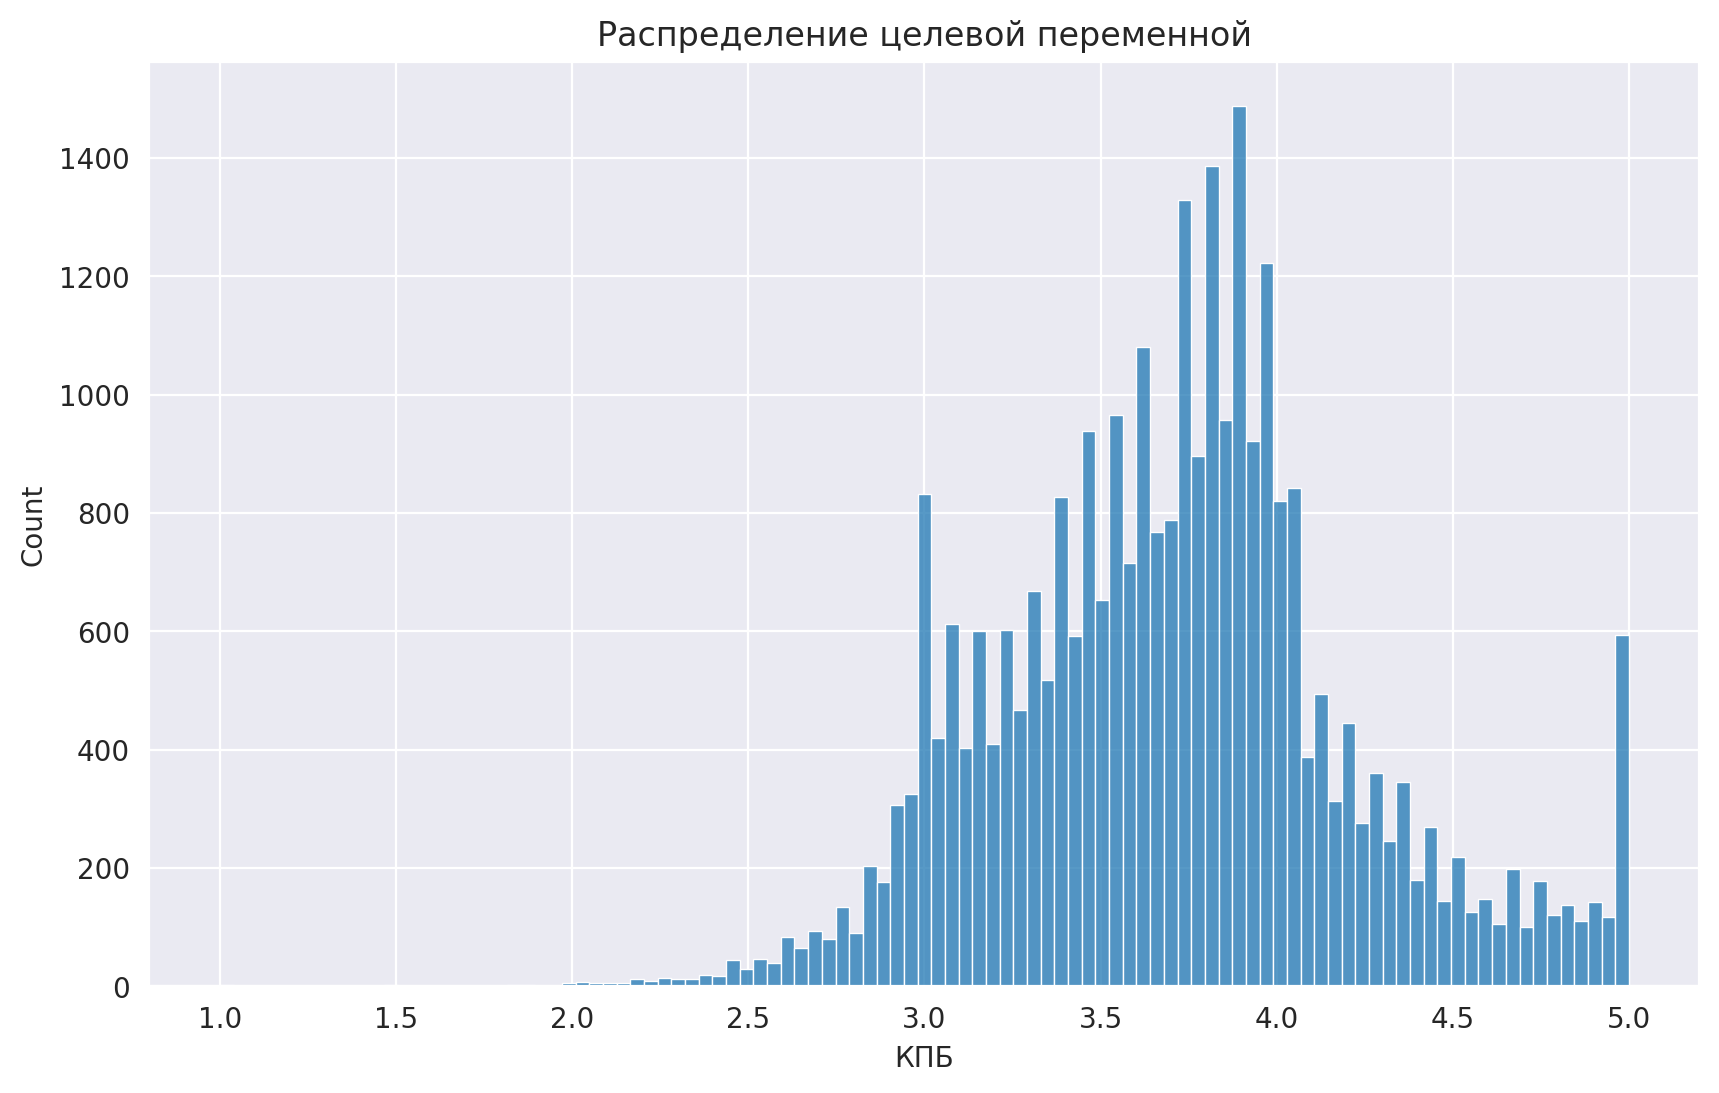

In [344]:
plt.figure(figsize=(10,6), dpi=200)
sns.histplot(data=data, x='КПБ')
plt.title('Распределение целевой переменной');

In [364]:
from scipy.stats import boxcox

In [366]:
data['target_transformed'], _ = boxcox(data['КПБ'] + 1)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


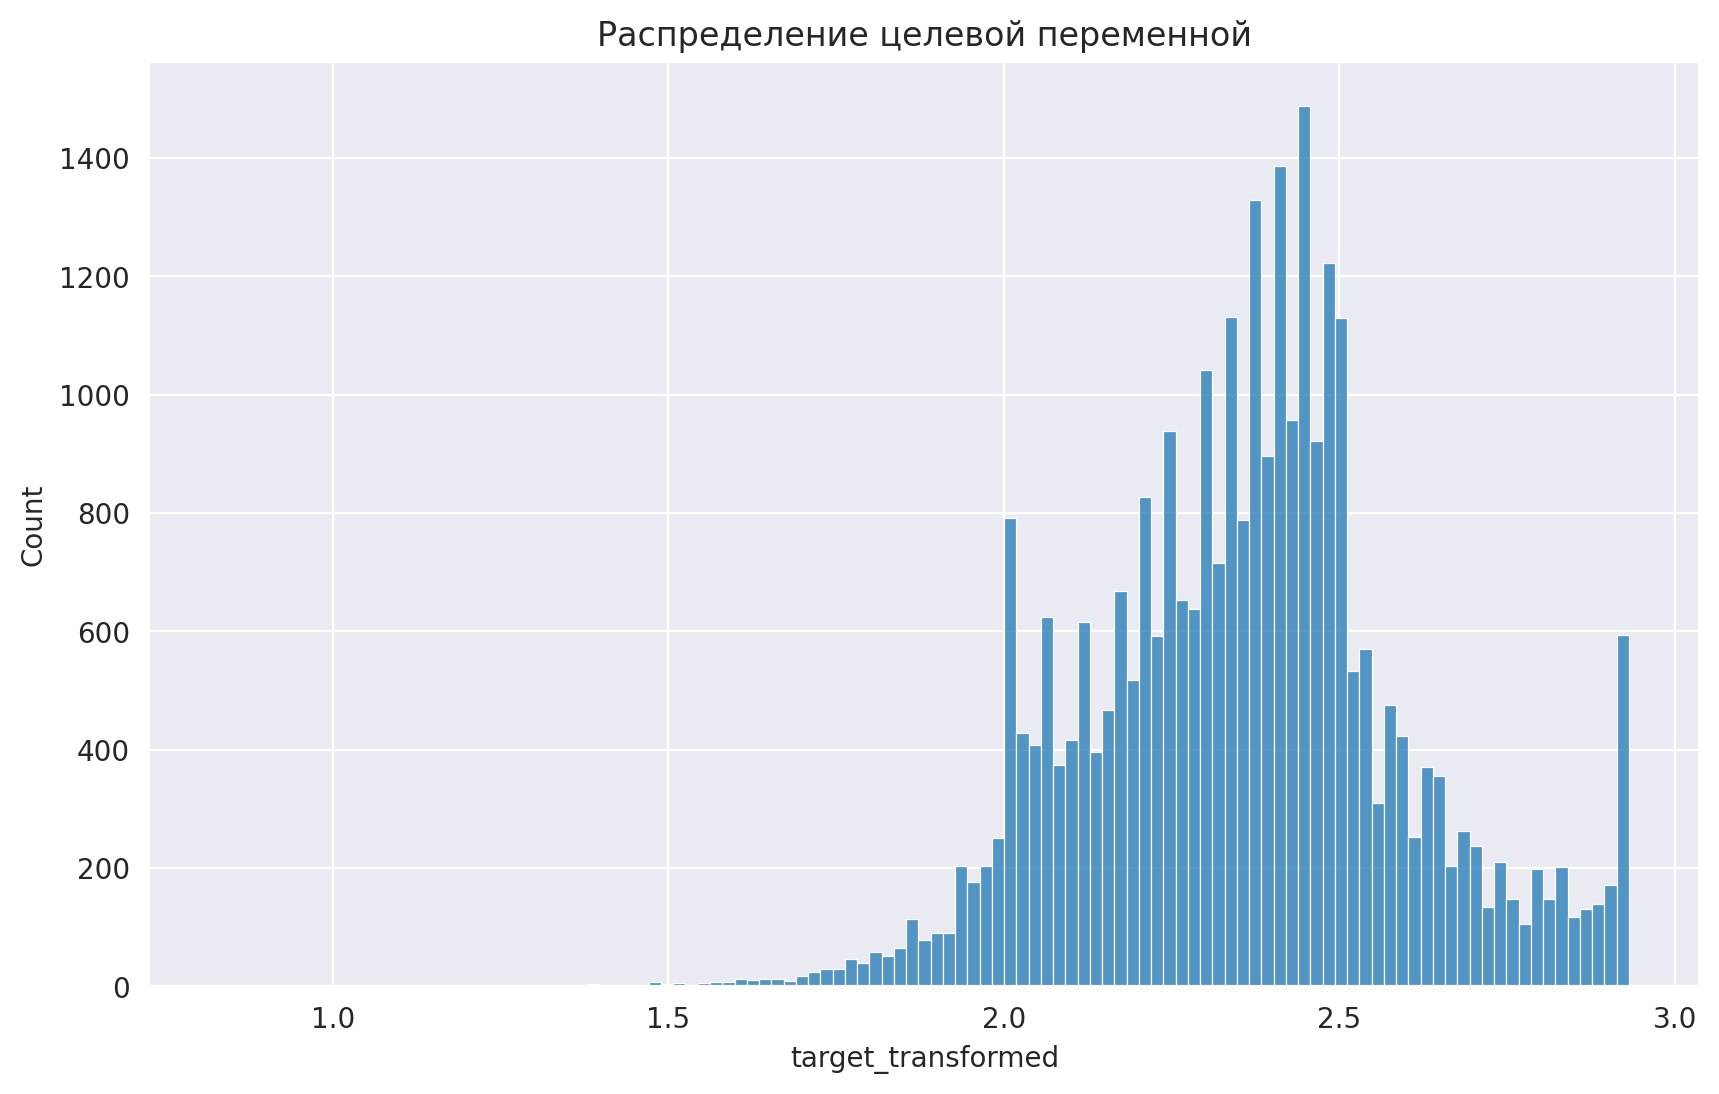

In [368]:
plt.figure(figsize=(10,6), dpi=200)
sns.histplot(data=data, x='target_transformed')
plt.title('Распределение целевой переменной');

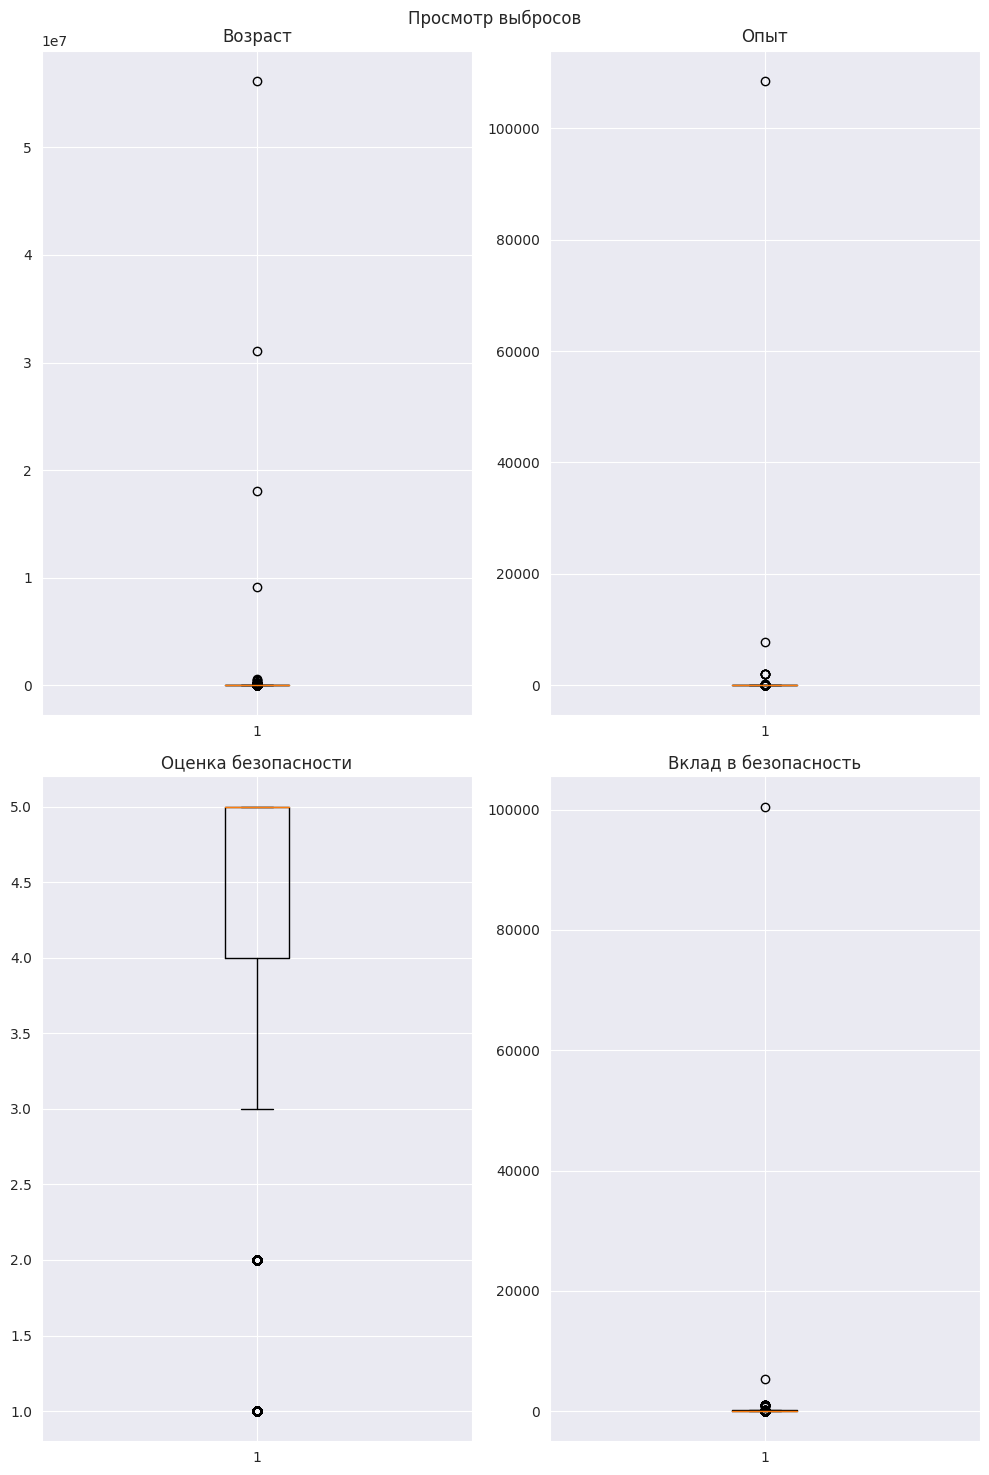

In [246]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Просмотр выбросов')
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0, 0].boxplot(data['Age'])
axs[0, 0].set_title('Возраст')
axs[0, 1].boxplot(data['Experience'])
axs[0, 1].set_title('Опыт')
axs[1, 0].boxplot(data['Security status'])
axs[1, 0].set_title('Оценка безопасности')
axs[1, 1].boxplot(data["Contribution to the company's security"])
axs[1, 1].set_title('Вклад в безопасность')
fig.tight_layout()

In [247]:
data = data[(data['Age'] <= 100) & (data['Age'] >= 18)]
data = data[(data['Experience'] <= 60) & (data['Experience'] >= 0)]
data = data[(data["Contribution to the company's security"] <= 100) &
            (data["Contribution to the company's security"] >= 0)]

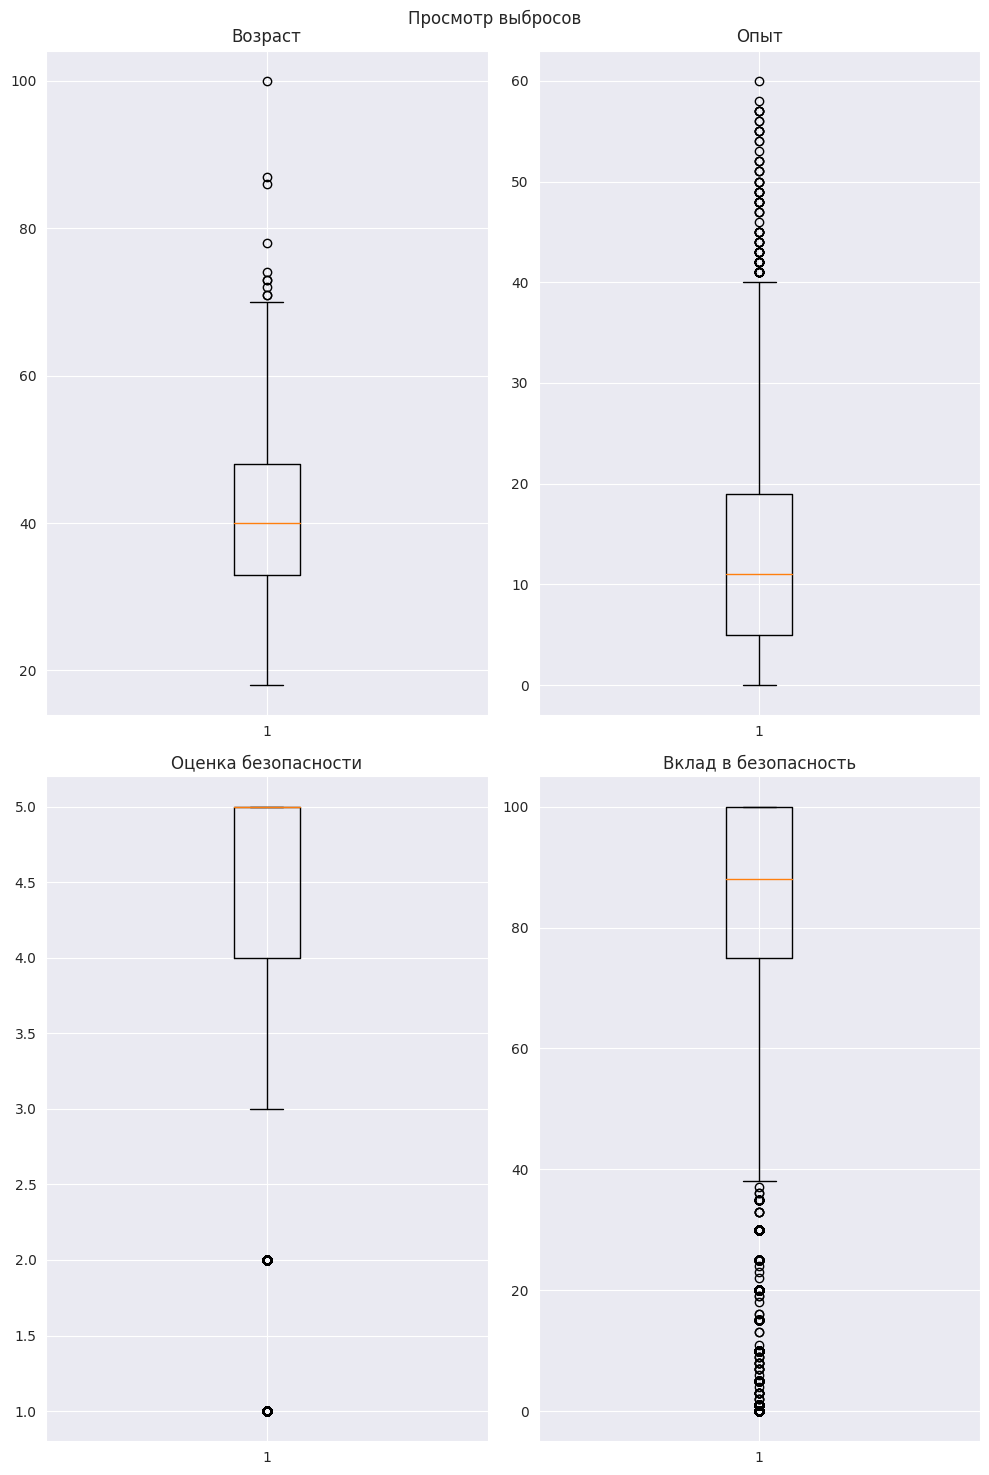

In [248]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Просмотр выбросов')
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0, 0].boxplot(data['Age'])
axs[0, 0].set_title('Возраст')
axs[0, 1].boxplot(data['Experience'])
axs[0, 1].set_title('Опыт')
axs[1, 0].boxplot(data['Security status'])
axs[1, 0].set_title('Оценка безопасности')
axs[1, 1].boxplot(data["Contribution to the company's security"])
axs[1, 1].set_title('Вклад в безопасность')
fig.tight_layout()

In [249]:
len(data)

30341

# Предобработка выбросов с помощью IQR

In [221]:
for column in ['Age', 'Experience', "Contribution to the company's security", "Security status"]:
    q1, q3 = data[column].quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    data = data[(data[column] >= low) & (data[column] <= high)]

In [222]:
len(data)

28108

# Подготовка данных к модели

In [369]:
X = data.drop(['КПБ', 'target_transformed'], axis=1)
y = data[['target_transformed']]

In [188]:
y.dtypes

КПБ    float64
dtype: object

In [189]:
X.dtypes

Age                                        int64
Experience                                 int64
Post                                      object
The ability to perform security           object
There were security errors                object
There are risks at work                   object
Security status                            int64
Contribution to the company's security     int64
Participation in the audit                object
Interrupt work in case of danger          object
dtype: object

In [370]:
categorical_columns = ['Post', 'The ability to perform security', 'There were security errors',
                      'There are risks at work', 'Participation in the audit',
                      'Interrupt work in case of danger']
int_columns = ['Age', 'Experience', "Contribution to the company's security"]
X[int_columns] = X[int_columns].astype('int32')
num_columns = ['Age', 'Experience', 'Security status', "Contribution to the company's security"]

In [225]:
assert len(categorical_columns) + len(num_columns) == 10

In [371]:
def encode(df, cols):
    encode_dict = {}
    for col in cols:
        print(f'{col}: преобразовалась')
        label_encoder = LabelEncoder()
        label_encoder = label_encoder.fit(df[col].values) 
        df[col] = label_encoder.transform(df[col].values)
        encode_dict[col] = label_encoder
    return df, encode_dict

X_cat, encode_dict = encode(X, categorical_columns)

Post: преобразовалась
The ability to perform security: преобразовалась
There were security errors: преобразовалась
There are risks at work: преобразовалась
Participation in the audit: преобразовалась
Interrupt work in case of danger: преобразовалась


In [253]:
encode_dict

{'Post': LabelEncoder(),
 'The ability to perform security': LabelEncoder(),
 'There were security errors': LabelEncoder(),
 'There are risks at work': LabelEncoder(),
 'Participation in the audit': LabelEncoder(),
 'Interrupt work in case of danger': LabelEncoder()}

In [372]:
scaler_dict = {}
for col in num_columns:
    scaler = StandardScaler()
    scaler_dict[col] = scaler.fit(X[col].values.reshape(-1, 1))
    X[col] = scaler_dict[col].transform(X[col].values.reshape(-1, 1))

In [373]:
X.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger
0,0.595727,0.800924,3,0,2,0,0.762012,-0.266675,0,0
1,-0.361588,0.253179,3,0,2,2,0.762012,0.831226,0,0
2,-0.042483,0.253179,3,0,2,0,0.762012,0.831226,1,0
3,0.063886,0.691375,0,0,0,0,0.762012,0.831226,0,0
4,-0.255220,0.472277,2,0,0,0,0.762012,0.831226,1,1


In [196]:
scaler_dict

{'Age': StandardScaler(),
 'Experience': StandardScaler(),
 'Security status': StandardScaler(),
 "Contribution to the company's security": StandardScaler()}

## Добавление полиномиальных признаков

In [319]:
poly = PolynomialFeatures(2)
poly.fit(X)
X = pd.DataFrame(poly.transform(X))

In [310]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,1.0,0.595727,0.800924,3.0,0.0,2.0,0.0,0.762012,-0.266675,0.0,...,0.580662,-0.203209,0.000000,0.000000,0.071115,-0.000000,-0.000000,0.0,0.0,0.0
1,1.0,-0.361588,0.253179,3.0,0.0,2.0,2.0,0.762012,0.831226,0.0,...,0.580662,0.633404,0.000000,0.000000,0.690937,0.000000,0.000000,0.0,0.0,0.0
2,1.0,-0.042483,0.253179,3.0,0.0,2.0,0.0,0.762012,0.831226,1.0,...,0.580662,0.633404,0.762012,0.000000,0.690937,0.831226,0.000000,1.0,0.0,0.0
3,1.0,0.063886,0.691375,0.0,0.0,0.0,0.0,0.762012,0.831226,0.0,...,0.580662,0.633404,0.000000,0.000000,0.690937,0.000000,0.000000,0.0,0.0,0.0
4,1.0,-0.255220,0.472277,2.0,0.0,0.0,0.0,0.762012,0.831226,1.0,...,0.580662,0.633404,0.762012,0.762012,0.690937,0.831226,0.831226,1.0,1.0,1.0


## Рассмотрим корреляцию признаков

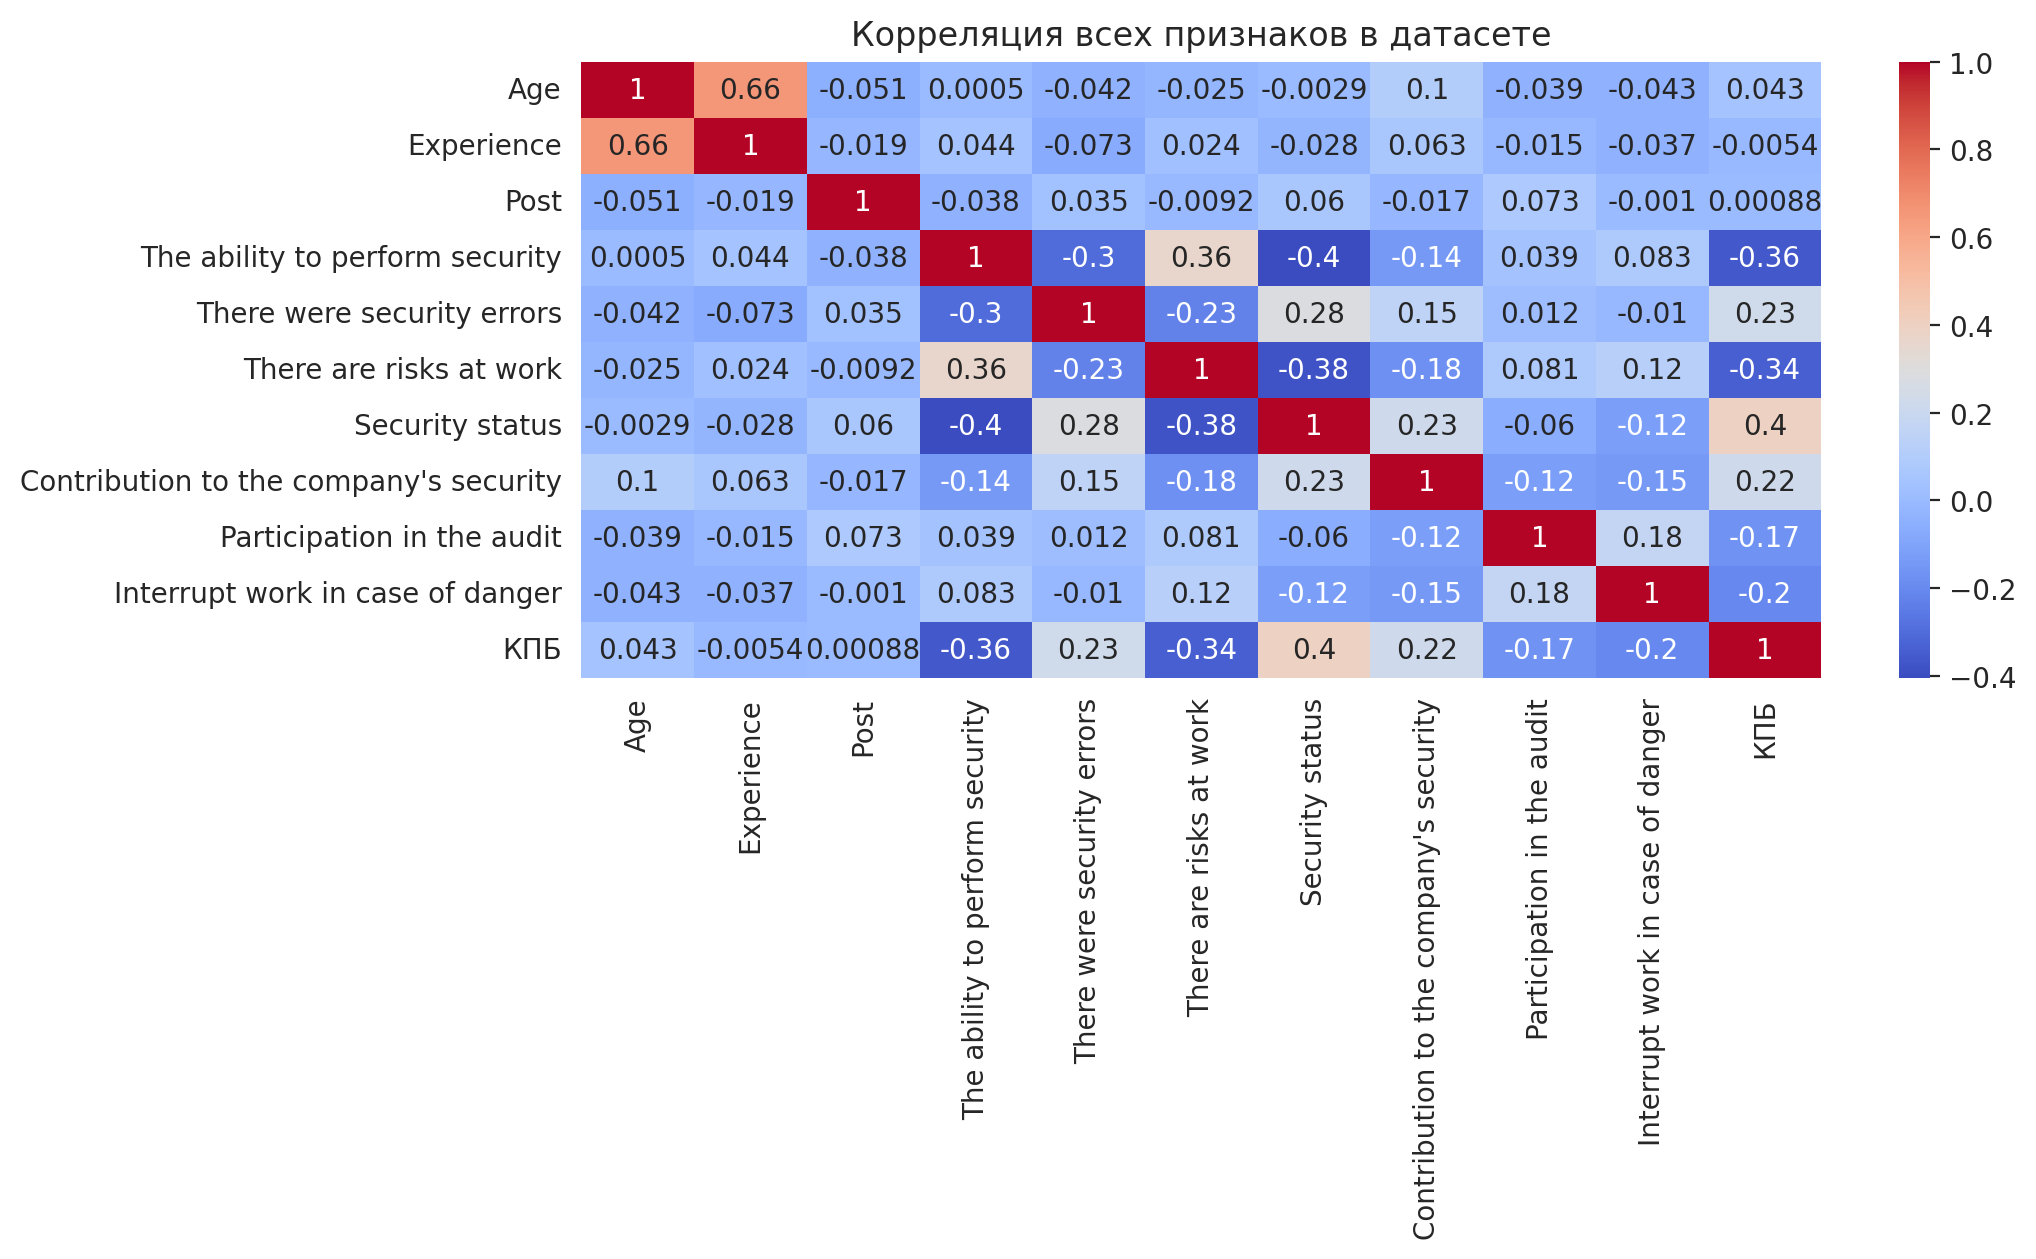

In [318]:
plt.figure(figsize=(10, 4), dpi=200)
sns.heatmap(pd.concat([X, y], axis=1).corr(), cmap='coolwarm', annot=True);
plt.title('Корреляция всех признаков в датасете');

In [374]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [375]:
X_train.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger
15632,-0.787062,-0.294567,2,0,2,0,0.762012,-0.486255,1,1
23094,0.914833,0.253179,0,0,2,0,0.762012,0.831226,0,0
1288,-1.212535,-1.170959,4,0,2,2,0.762012,-2.901637,1,2
21634,-1.318904,-0.623214,4,0,2,2,0.762012,0.831226,1,0
14850,0.382991,0.143629,2,2,2,1,-1.939420,-3.560377,1,0


## Отбор признаков с помощью случайного леса 

In [334]:
rf_importance = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_importance.fit(X_train, y_train)
importances = rf_importance.feature_importances_

<ipython-input-334-e320f24f4001>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_importance.fit(X_train, y_train)


<Figure size 1200x800 with 0 Axes>

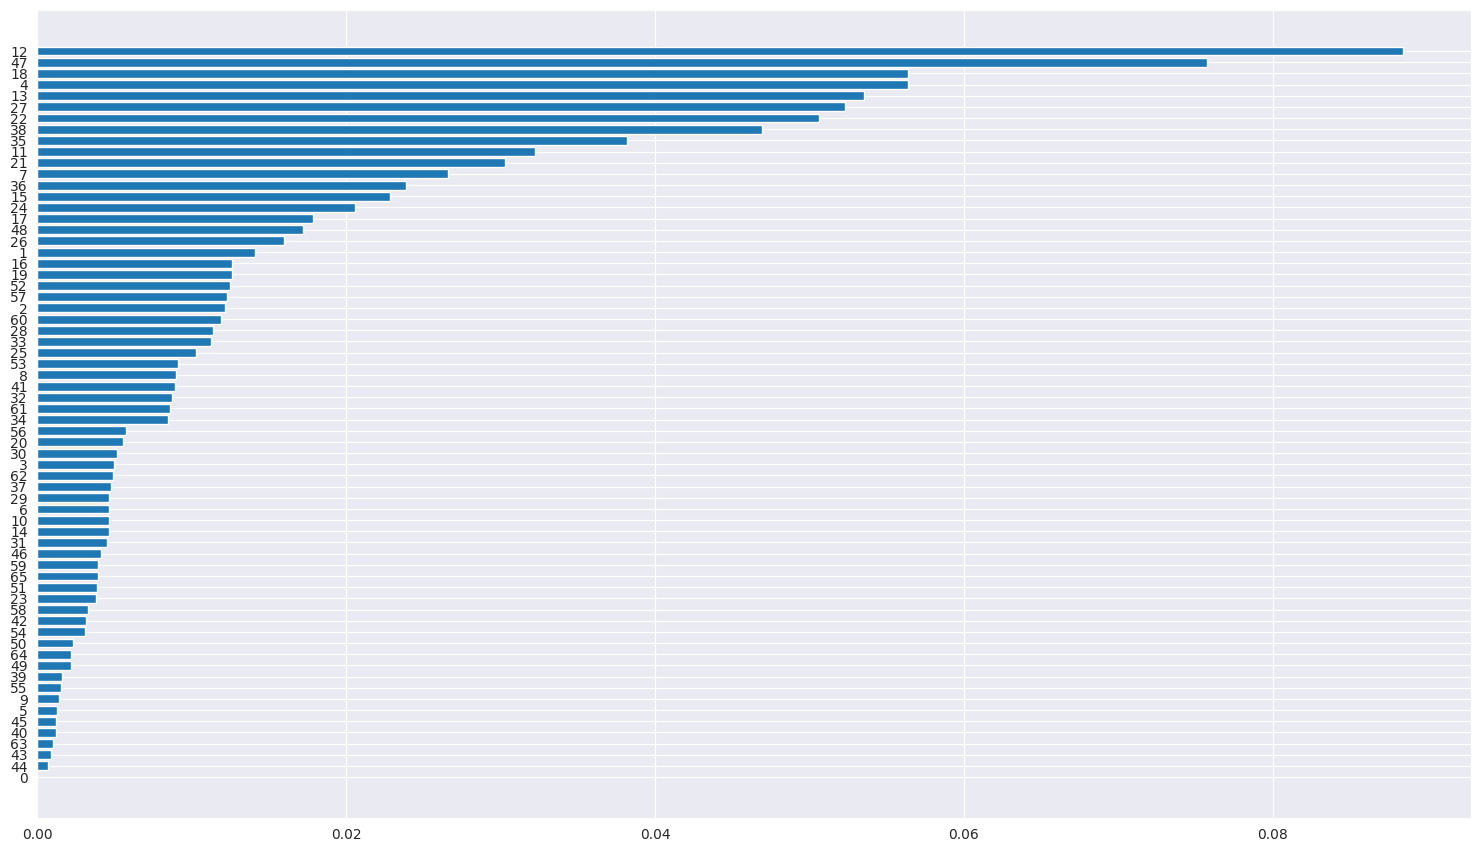

In [337]:
plt.figure(figsize=(12,8))
indices = np.argsort(importances)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

In [361]:
X_train = X_train.drop(indices[:51],axis=1)

# Baseline модель

In [380]:
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train, y_train, train_size=0.9, \
                                                                     random_state=42)

base_model = LinearRegression()
base_model.fit(X_train_base, y_train_base)
preds = base_model.predict(X_val_base)

print(f'Вычисленное отклонение rmse: {np.sqrt(mean_squared_error(y_val_base, preds))}')

Вычисленное отклонение rmse: 0.19992848384448852


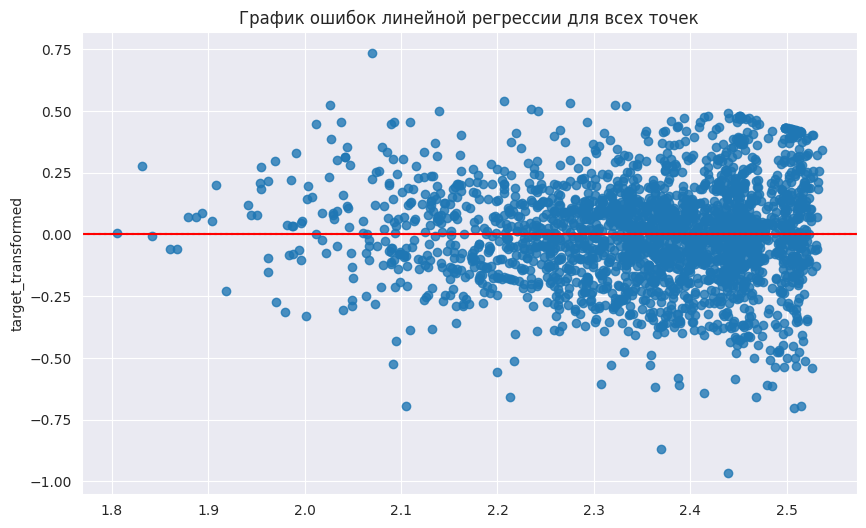

In [377]:
plt.figure(figsize=(10,6), dpi=100)
sns.residplot(x=preds, y=y_val_base);
plt.axhline(y=0, color='r');
plt.title('График ошибок линейной регрессии для всех точек');

# XGBoost, Catboost

In [203]:
def training_model_with_randomsearch(model, X_train, y_train, X_test, y_test, params_dict):
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params_dict,
        n_iter=10,
        cv=3,
        scoring='neg_mean_squared_error', 
        verbose=1
    )
    random_search.fit(X_train, y_train)
    preds = random_search.predict(X_test)
    print("Лучшие гиперпараметры:", random_search.best_params_)
    print(f'Вычисленное значение rmse: {np.sqrt(mean_squared_error(y_test, preds))}')

In [204]:
def training_model_with_gridsearch(model, X_train, y_train, X_test, y_test, params_dict):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params_dict,
        cv=3,
        scoring='neg_mean_squared_error',
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    preds = grid_search.predict(X_test)
    print("Лучшие гиперпараметры:", grid_search.best_params_)
    print(f'Вычисленное значение rmse: {np.sqrt(mean_squared_error(y_test, preds))}')

**XGBoost**

In [ ]:
params_dict = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.5, 0.7, 0.8, 0.9]
}

xgb = XGBRegressor(tree_method='gpu_hist', random_state=42)
training_model_with_randomsearch(xgb, X_train_base, y_train_base, X_val_base, y_val_base, params_dict)

In [ ]:
params_dict = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [5, 7, 9],
    'min_child_weight': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9]
}

xgb = XGBRegressor(tree_method='gpu_hist', random_state=42)
training_model_with_gridsearch(xgb, X_train_base, y_train_base, X_val_base, y_val_base, params_dict)

**Catboost**

In [205]:
params = {
    'depth': [8, 10, 12],
    'learning_rate': [0.05, 0.1],
    'iterations': [500, 700, 900],
    'l2_leaf_reg': [7, 9, 11],
}
cat = CatBoostRegressor(task_type='GPU', verbose=0)

In [206]:
training_model_with_randomsearch(cat, X_train_base, y_train_base, X_val_base, y_val_base, params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие гиперпараметры: {'learning_rate': 0.05, 'l2_leaf_reg': 11, 'iterations': 500, 'depth': 10}
Вычисленное значение rmse: 0.4179921029289991


In [381]:
cat = CatBoostRegressor(task_type='GPU', verbose=0, learning_rate=0.05, l2_leaf_reg=11, iterations=500, depth=10)
cat.fit(X_train_base, y_train_base)
preds = cat.predict(X_val_base)
print(f'Вычисленное значение rmse: {np.sqrt(mean_squared_error(y_val_base, preds))}')

Вычисленное значение rmse: 0.19615660692769282


In [ ]:
training_model_with_gridsearch(cat, X_train_base, y_train_base, X_val_base, y_val_base, params)

# Подготовка данных к нейронке

In [382]:
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=42)

In [383]:
class MyDataset(Dataset):
    def __init__(self, df, num_cols, cat_cols, targets):
        self.num_data = df[num_cols]
        self.cat_data = df[cat_cols]
        self.targets = targets

    def __len__(self):
        return len(self.num_data) 

    def __getitem__(self, idx):
        return torch.FloatTensor(self.num_data.iloc[idx].values), torch.LongTensor(self.cat_data.iloc[idx].values), (self.targets.iloc[idx].values).astype('float32')

In [384]:
train_dataset = MyDataset(X_train_new, num_columns, categorical_columns, y_train_new)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = MyDataset(X_val, num_columns, categorical_columns, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Архитектура нейросети

**Определяем количество эмбеддингов.**

In [61]:
cat_dims = [X[col].nunique() for col in categorical_columns]
cat_embs = [(dim, min(50,(dim+1)//2)) for dim in cat_dims]
cat_embs

[(8, 4), (3, 2), (3, 2), (3, 2), (2, 1), (3, 2)]

In [62]:
class MyModel(nn.Module):
    def __init__(self, input_shape, embeddings_shape):
        super(MyModel, self).__init__()
        self.relu = nn.ReLU()

        # Создание эмбеддингов
        self.embeddings = nn.ModuleList(nn.Embedding(dim1,dim2) for dim1, dim2 in embeddings_shape)
        len_emb = sum([dim2 for dim1, dim2 in embeddings_shape])

        # Полносвязные слои с дропаутом и пакетной нормализацией
        self.linear_1 = nn.Linear(input_shape + len_emb, 128)
        self.dropout1 = nn.Dropout(0.35)

        self.bn1 = nn.BatchNorm1d(128)
        
        self.linear_2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.35)

        self.bn2 = nn.BatchNorm1d(64)
        
        self.linear_3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.35)

        self.bn3 = nn.BatchNorm1d(32)
        
        self.linear_4 = nn.Linear(32, 16)
        self.dropout4 = nn.Dropout(0.35)

        self.bn4 = nn.BatchNorm1d(16)
        
        self.linear_5 = nn.Linear(16, 1)
        
    def forward(self, num_batch, cat_batch):
        # Работаем с категориальными данными 
        x_cat = [embedding_layer(cat_batch[:, i]) for i, embedding_layer in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, 1)
        x = torch.cat([x_cat, num_batch], 1)

        # Основной проход
        x = self.relu(self.linear_1(x))
        x = self.dropout1(x)
        
        x = self.bn1(x)
        
        x = self.relu(self.linear_2(x))
        x = self.dropout2(x)
        
        x = self.bn2(x)
        
        x = self.relu(self.linear_3(x))
        x = self.dropout3(x)
        
        x = self.bn3(x)
        
        x = self.relu(self.linear_4(x))
        x = self.dropout4(x)
        
        x = self.bn4(x)
        
        out = self.linear_5(x)
        return out

In [63]:
model = MyModel(len(num_columns), cat_embs).to(device)
print(model)

MyModel(
  (relu): ReLU()
  (embeddings): ModuleList(
    (0): Embedding(8, 4)
    (1-3): 3 x Embedding(3, 2)
    (4): Embedding(2, 1)
    (5): Embedding(3, 2)
  )
  (linear_1): Linear(in_features=17, out_features=128, bias=True)
  (dropout1): Dropout(p=0.35, inplace=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.35, inplace=False)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_3): Linear(in_features=64, out_features=32, bias=True)
  (dropout3): Dropout(p=0.35, inplace=False)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_4): Linear(in_features=32, out_features=16, bias=True)
  (dropout4): Dropout(p=0.35, inplace=False)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_5): Linear(in_features=16, 

In [64]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses, val_losses = [], []
y_preds, y_trues = [], []
epochs = 20
for epoch in range(epochs):
    # ТРЕНИРОВКА
    model.train()
    train_loop = tqdm(train_loader)
    train_loss_epoch = 0
    for num_data, cat_data, targets in train_loop:
        num_data = num_data.to(device)
        cat_data = cat_data.to(device)
        targets = targets.to(device)
        
        # прямой проход
        preds = model(num_data, cat_data)
        loss = criterion(preds, targets)
        train_loss_epoch += loss.item()
        

        # обратное распространение
        opt.zero_grad()
        loss.backward()
        opt.step()

    mean_train_loss = train_loss_epoch / len(train_loader)
    train_losses.append(mean_train_loss)
    print(f"Epoch {epoch+1}/{epochs}, train_loss: {mean_train_loss:.4f}")

    # ВАЛИДАЦИЯ
    model.eval()
    val_loop = tqdm(val_loader)
    val_loss_epoch = 0
    with torch.no_grad():
        for num_data, cat_data, targets in val_loop:
            num_data = num_data.to(device)
            cat_data = cat_data.to(device)
            targets = targets.to(device)

            # оценка
            preds = model(num_data, cat_data)
            loss = criterion(preds, targets)
            val_loss_epoch += loss.item()

            y_preds.append(preds)
            y_trues.append(targets)

    mean_val_loss = val_loss_epoch / len(val_loader)
    val_losses.append(mean_val_loss)
    print(f"Epoch {epoch+1}/{epochs}, val_loss: {mean_val_loss:.4f}")

100%|██████████| 329/329 [00:04<00:00, 73.52it/s]


Epoch 1/20, train_loss: 7.4886


100%|██████████| 37/37 [00:00<00:00, 111.49it/s]


Epoch 1/20, val_loss: 0.7703


100%|██████████| 329/329 [00:03<00:00, 86.86it/s]


Epoch 2/20, train_loss: 0.7700


100%|██████████| 37/37 [00:00<00:00, 104.15it/s]


Epoch 2/20, val_loss: 0.2238


100%|██████████| 329/329 [00:03<00:00, 83.07it/s]


Epoch 3/20, train_loss: 0.3889


100%|██████████| 37/37 [00:00<00:00, 111.97it/s]


Epoch 3/20, val_loss: 0.2198


100%|██████████| 329/329 [00:03<00:00, 86.78it/s]


Epoch 4/20, train_loss: 0.2759


100%|██████████| 37/37 [00:00<00:00, 110.61it/s]


Epoch 4/20, val_loss: 0.2107


100%|██████████| 329/329 [00:03<00:00, 86.19it/s]


Epoch 5/20, train_loss: 0.2347


100%|██████████| 37/37 [00:00<00:00, 108.94it/s]


Epoch 5/20, val_loss: 0.2080


100%|██████████| 329/329 [00:03<00:00, 86.02it/s]


Epoch 6/20, train_loss: 0.2161


100%|██████████| 37/37 [00:00<00:00, 111.15it/s]


Epoch 6/20, val_loss: 0.2045


100%|██████████| 329/329 [00:03<00:00, 85.99it/s]


Epoch 7/20, train_loss: 0.2115


100%|██████████| 37/37 [00:00<00:00, 108.33it/s]


Epoch 7/20, val_loss: 0.2022


100%|██████████| 329/329 [00:03<00:00, 84.92it/s]


Epoch 8/20, train_loss: 0.2058


100%|██████████| 37/37 [00:00<00:00, 111.17it/s]


Epoch 8/20, val_loss: 0.2003


100%|██████████| 329/329 [00:03<00:00, 87.21it/s]


Epoch 9/20, train_loss: 0.2043


100%|██████████| 37/37 [00:00<00:00, 112.12it/s]


Epoch 9/20, val_loss: 0.1970


100%|██████████| 329/329 [00:03<00:00, 86.04it/s]


Epoch 10/20, train_loss: 0.2022


100%|██████████| 37/37 [00:00<00:00, 111.89it/s]


Epoch 10/20, val_loss: 0.2008


100%|██████████| 329/329 [00:03<00:00, 86.14it/s]


Epoch 11/20, train_loss: 0.2012


100%|██████████| 37/37 [00:00<00:00, 108.30it/s]


Epoch 11/20, val_loss: 0.1938


100%|██████████| 329/329 [00:03<00:00, 85.84it/s]


Epoch 12/20, train_loss: 0.2003


100%|██████████| 37/37 [00:00<00:00, 110.73it/s]


Epoch 12/20, val_loss: 0.1922


100%|██████████| 329/329 [00:03<00:00, 86.79it/s]


Epoch 13/20, train_loss: 0.1983


100%|██████████| 37/37 [00:00<00:00, 111.09it/s]


Epoch 13/20, val_loss: 0.1935


100%|██████████| 329/329 [00:03<00:00, 86.26it/s]


Epoch 14/20, train_loss: 0.1972


100%|██████████| 37/37 [00:00<00:00, 102.12it/s]


Epoch 14/20, val_loss: 0.1918


100%|██████████| 329/329 [00:03<00:00, 86.56it/s]


Epoch 15/20, train_loss: 0.1967


100%|██████████| 37/37 [00:00<00:00, 108.38it/s]


Epoch 15/20, val_loss: 0.1951


100%|██████████| 329/329 [00:03<00:00, 84.52it/s]


Epoch 16/20, train_loss: 0.1952


100%|██████████| 37/37 [00:00<00:00, 112.40it/s]


Epoch 16/20, val_loss: 0.1881


100%|██████████| 329/329 [00:03<00:00, 85.85it/s]


Epoch 17/20, train_loss: 0.1960


100%|██████████| 37/37 [00:00<00:00, 110.33it/s]


Epoch 17/20, val_loss: 0.1895


100%|██████████| 329/329 [00:03<00:00, 86.56it/s]


Epoch 18/20, train_loss: 0.1944


100%|██████████| 37/37 [00:00<00:00, 111.47it/s]


Epoch 18/20, val_loss: 0.1924


100%|██████████| 329/329 [00:03<00:00, 85.66it/s]


Epoch 19/20, train_loss: 0.1935


100%|██████████| 37/37 [00:00<00:00, 111.98it/s]


Epoch 19/20, val_loss: 0.1937


100%|██████████| 329/329 [00:03<00:00, 87.50it/s]


Epoch 20/20, train_loss: 0.1936


100%|██████████| 37/37 [00:00<00:00, 111.81it/s]

Epoch 20/20, val_loss: 0.1944


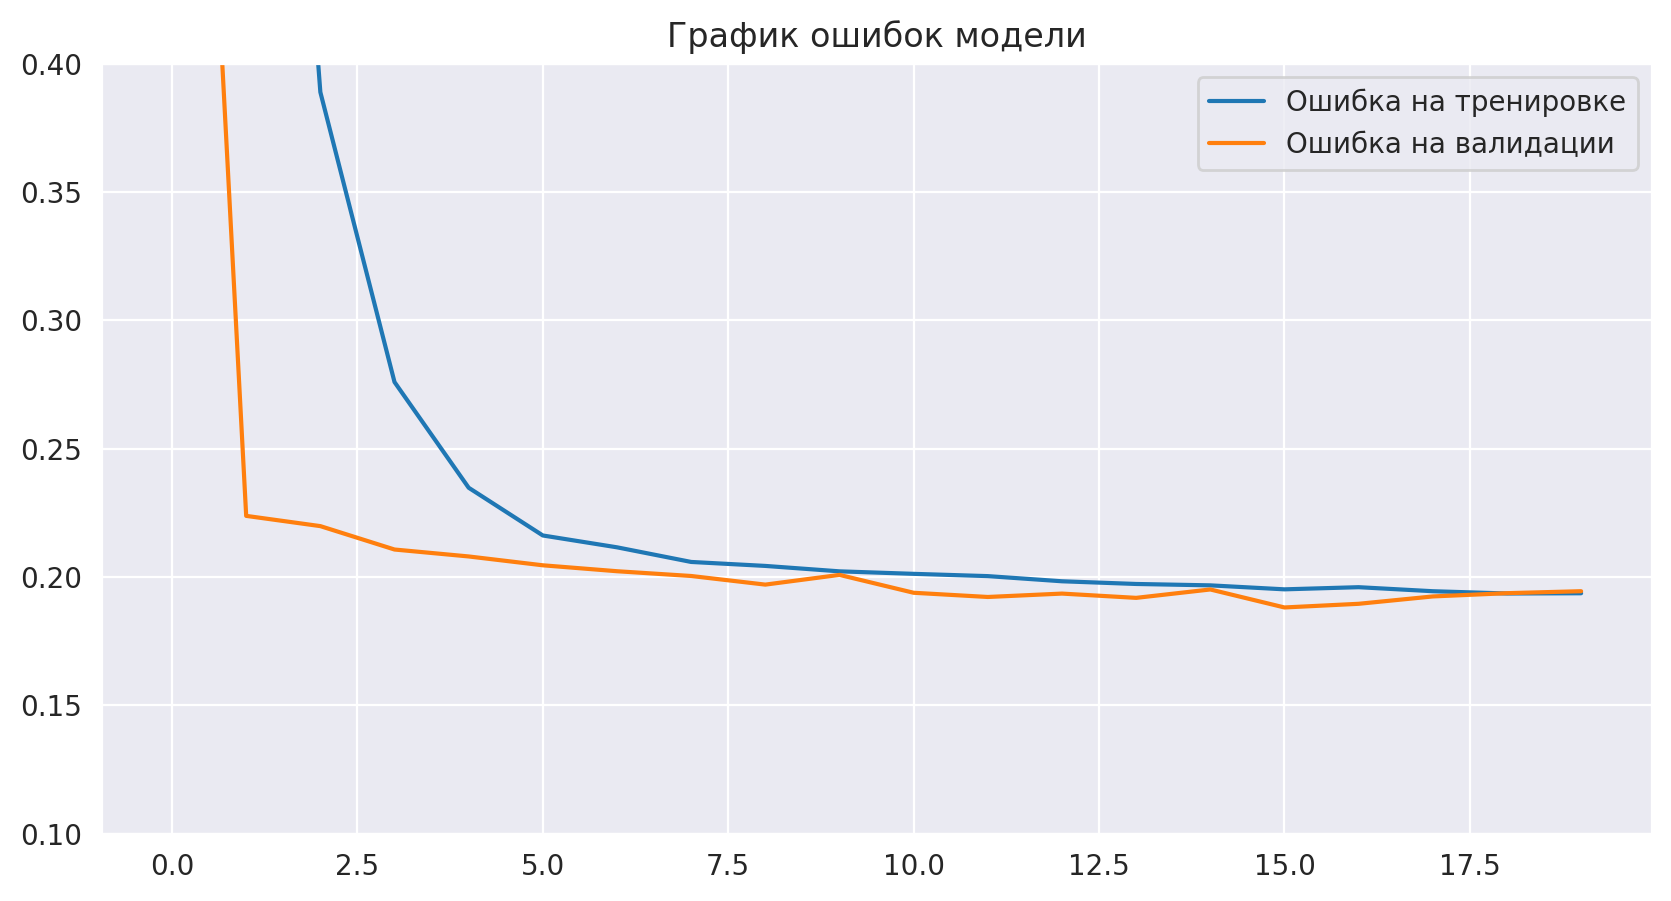

In [65]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(train_losses, label='Ошибка на тренировке')
plt.plot(val_losses, label='Ошибка на валидации')
plt.title('График ошибок модели')
plt.ylim([0.1, 0.4])
plt.legend()

In [76]:
def r2_score(y_true, y_pred):
    y_true_mean = torch.mean(y_true)
    ss_total = torch.sum((y_true - y_true_mean) ** 2)
    ss_residual = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - ss_residual / ss_total
    return r2.item()

In [111]:
y_preds = torch.cat(y_preds)
y_trues = torch.cat(y_trues)
r2_score(y_trues, y_preds)

0.251178503036499